# Assignment 1: NARMA10 task
## TDNN
Note: as a reference for keras tuner I used the documentation: https://www.tensorflow.org/tutorials/keras/keras_tuner

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import keras_tuner as kt
import pandas as pd

2023-05-12 09:00:26.900460: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-12 09:00:26.947554: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-12 09:00:26.948389: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 09:00:27.924012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def history_plot(history,window):
    plt.figure(figsize = (15,5))

    plt.subplot(121)
    plt.plot(history['loss'])
    plt.title(f'Loss (window:{window})')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.yscale('log')

    plt.subplot(122)
    plt.plot(history['val_loss'])
    plt.title(f'Validation Loss (window:{window})')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.yscale('log')
    plt.tight_layout()

    plt.savefig(f"plots/tdnn_loss_{window}.pdf")
    plt.show()

### Load the dataset

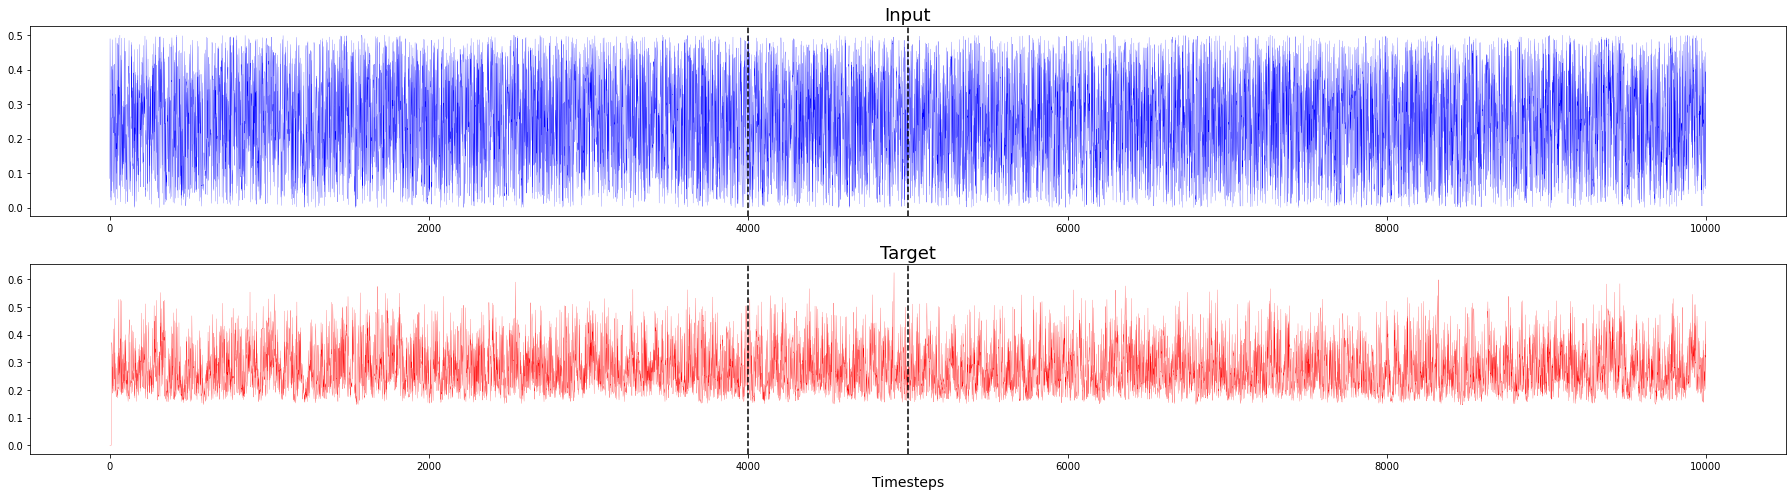

In [3]:
#load the data
x, y = np.loadtxt("NARMA10.csv", delimiter=",")


#split the dataset into training, validation and test
x_train = x[:4000]
x_valid = x[4000:5000] #validation
x_test = x[5000:]

y_train = y[:4000]
y_valid = y[4000:5000]
y_test = y[5000:]

#plot the data
t=np.arange(start=0,stop=len(x), step=1)
plt.figure(figsize = (25,7))
ax1 = plt.subplot(211)
plt.title('Input', fontsize=18)
ax1.plot(t,x, color = 'b', linewidth= 0.2)
ax1.axvline(x = 4000, color = 'black', linestyle= '--')
ax1.axvline(x = 5000, color = 'black', linestyle= '--')

ax2 = plt.subplot(212, sharex = ax1)
plt.title('Target', fontsize=18)
ax2.plot(t,y, color = 'r', linewidth = 0.2)
ax2.axvline(x = 4000, color = 'black', linestyle= '--')
ax2.axvline(x = 5000, color = 'black', linestyle= '--')
plt.xlabel('Timesteps', fontsize=14)
plt.tight_layout()

# Choose the window size

In [4]:
#size of the window we use to buffer the input
window_size = 10 # 10 is the minimum value from theory

Prepare the dataset to implement the tdnn:

In [5]:
# Prepare the input X and target Y in order to implement the tdnn
def get_XY(x, y, window):
    # Remove the first "window" elements from y array
    Y = y[window:]
    # X will be an array containing "len(Y)" arrays created using the sliding window
    X = []
    rows_x = len(Y)
    j = 0
    for i in range(rows_x):
        X = np.append(X,x[j:j+window])
        j = j + 1

    #reshape X so it can be fed to the Dense layer
    X =  np.reshape(X, (rows_x, 1, window)) 
    return X, Y 

#prepare the data
trainX, trainY = get_XY(x_train, y_train, window_size)
validX, validY = get_XY(x_valid, y_valid, window_size)
testX, testY = get_XY(x_test, y_test, window_size)

#check shape
print(trainX.shape,trainY.shape)

(3990, 1, 10) (3990,)


### Create the model
To do model selection, we actually create the "hypermodel", defining the hyperparameter search space as well as the architecture of the model.

In [6]:
def model_architecture(hidden_units, activation_h, activation_d, lr):
    model = Sequential()
    input_shape = (1, window_size) 
    model.add(Dense(units=hidden_units,input_shape=input_shape, activation=activation_h))
    model.add(Dense(units=1, activation=activation_d))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr),metrics=['mean_squared_error'])
    return model


def create_model(hp):

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 50-150
    hidden_units = hp.Int('units',  min_value=50, max_value=150, step=10)

    #Tune the activation function of the hidden layer
    activation_h = hp.Choice("activation_h", ["linear","relu", "tanh"])
    #Tune the activation function of the last layer
    activation_d = hp.Choice("activation_d", ["linear","relu"])

    # Tune the learning rate for the optimizer
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


    # call model-building code with the hyperparameter values.
    model = model_architecture(
        hidden_units=hidden_units, activation_d=activation_d, activation_h=activation_h, lr=lr
    )
    return model


Instantiate hyperparameter tuner

In [7]:
# use random search to find optimal hyperparameters
tuner = kt.RandomSearch(
                     hypermodel = create_model,
                     objective='val_mean_squared_error',
                     max_trials=20,
                     #overwrite=True,
                     directory='tuner',
                     project_name=f'tuner_tdnn_{window_size}'
                     )

tuner.search_space_summary()

INFO:tensorflow:Reloading Tuner from tuner/tuner_tdnn_10/tuner0.json
Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
activation_h (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu', 'tanh'], 'ordered': False}
activation_d (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


Create a callback to stop training early after reaching a certain value for the validation loss.

In [8]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# COME MAI FUNZIONA SOLO CON BS = 1 ???

In [9]:
#batch size 
bs = 1
#epochs for the search phase
ep = 8

In [10]:
tuner.search(trainX, trainY, epochs=ep, batch_size=bs, validation_data = (validX, validY), callbacks=[stop_early])
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Completed hyperparameters search.\n
Otimal number of units of hidden layer = {best_hps.get('units')} \n
Optimal learning rate for the optimizer = {best_hps.get('learning_rate')} \n
Optimal activation function for the hidden layer = {best_hps.get('activation_h')} \n
Optimal activation function for the dense layer = {best_hps.get('activation_d')}
""")

INFO:tensorflow:Oracle triggered exit

Completed hyperparameters search.

Otimal number of units of hidden layer = 60 

Optimal learning rate for the optimizer = 0.001 

Optimal activation function for the hidden layer = relu 

Optimal activation function for the dense layer = relu



Find the optimal number of epochs

In [11]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
model.summary()
history = model.fit(trainX, trainY, epochs=50, batch_size=bs, verbose=2, validation_data = (validX, validY))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 60)             660       
                                                                 
 dense_1 (Dense)             (None, 1, 1)              61        
                                                                 
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
3990/3990 - 6s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 8.9878e-04 - val_mean_squared_error: 8.9878e-04 - 6s/epoch - 1ms/step
Epoch 2/50
3990/3990 - 5s - loss: 7.1620e-04 - mean_squared_error: 7.1620e-04 - val_loss: 5.7910e-04 - val_mean_squared_error: 5.7910e-04 - 5s/epoch - 1ms/step
Epoch 3/50
3990/3990 - 5s - loss: 6.3482e-04 - mean_squared_error: 6.3482e-04 - val_loss: 5.1136e-04 - val_mean_squared_error: 5.1136e-04 - 5s

Find best epoch:

In [12]:
val_mse_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 37


Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [13]:
hypermodel = tuner.hypermodel.build(best_hps)

In [14]:
# Retrain the model
history = hypermodel.fit(trainX, trainY, epochs=best_epoch, batch_size=bs, verbose=2, validation_data = (validX, validY)).history

Epoch 1/37
3990/3990 - 5s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 9.5105e-04 - val_mean_squared_error: 9.5105e-04 - 5s/epoch - 1ms/step
Epoch 2/37
3990/3990 - 5s - loss: 7.4333e-04 - mean_squared_error: 7.4333e-04 - val_loss: 6.1842e-04 - val_mean_squared_error: 6.1842e-04 - 5s/epoch - 1ms/step
Epoch 3/37
3990/3990 - 5s - loss: 6.5812e-04 - mean_squared_error: 6.5812e-04 - val_loss: 8.9117e-04 - val_mean_squared_error: 8.9117e-04 - 5s/epoch - 1ms/step
Epoch 4/37
3990/3990 - 5s - loss: 6.3279e-04 - mean_squared_error: 6.3279e-04 - val_loss: 6.0189e-04 - val_mean_squared_error: 6.0189e-04 - 5s/epoch - 1ms/step
Epoch 5/37
3990/3990 - 5s - loss: 5.7369e-04 - mean_squared_error: 5.7369e-04 - val_loss: 5.2789e-04 - val_mean_squared_error: 5.2789e-04 - 5s/epoch - 1ms/step
Epoch 6/37
3990/3990 - 5s - loss: 5.4439e-04 - mean_squared_error: 5.4439e-04 - val_loss: 4.8948e-04 - val_mean_squared_error: 4.8948e-04 - 5s/epoch - 1ms/step
Epoch 7/37
3990/3990 - 5s - loss: 5.2857e-04 - m

### Make plots of the loss and validation loss

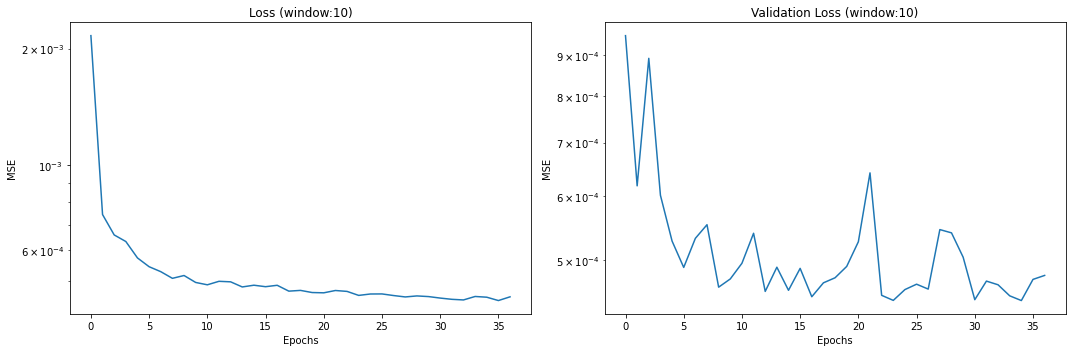

In [15]:
history_plot(history,window_size)

Save history data

In [16]:
hist_df = pd.DataFrame(history) 
# save to json:  
hist_json_file = f'history_tdnn_{window_size}.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

To load history data use:

In [17]:
#history = pd.read_json('history_tdnn_10.json')

Save the model

In [18]:
hypermodel.save(f'keras_model_tdnn_{window_size}')

2023-05-12 09:07:31.840426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_2_input' with dtype float and shape [?,1,10]
	 [[{{node dense_2_input}}]]
2023-05-12 09:07:31.862969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_2_input' with dtype float and shape [?,1,10]
	 [[{{node dense_2_input}}]]
2023-05-12 09:07:31.872393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,10]
	 [[{{n

INFO:tensorflow:Assets written to: keras_model_tdnn_10/assets


INFO:tensorflow:Assets written to: keras_model_tdnn_10/assets


Command to (eventually) load the saved model:

In [19]:
#hypermodel = keras.models.load_model('keras_model_tdnn_10')

calculate mse on validation in order to compare with the model with different window size

In [20]:
mse10 = hypermodel.evaluate(validX, validY, batch_size=bs)[0] 

990/990 [==============================] - 1s 846us/step - loss: 4.7840e-04 - mean_squared_error: 4.7840e-04


# Try with different window size

In [21]:
window_size = 15 #15

if we change the window size, we have to change the dataset structure

In [22]:
#prepare the data
trainX, trainY = get_XY(x_train, y_train, window_size)
validX, validY = get_XY(x_valid, y_valid, window_size)
testX, testY = get_XY(x_test, y_test, window_size)

#check shape
print(trainX.shape,trainY.shape)

(3985, 1, 15) (3985,)


### Create the model

In [23]:
def model_architecture(hidden_units, activation_h, activation_d, lr):
    model = Sequential()
    input_shape = (1, window_size) 
    model.add(Dense(units=hidden_units,input_shape=input_shape, activation=activation_h))
    model.add(Dense(units=1, activation=activation_d))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr),metrics=['mean_squared_error'])
    return model


def create_model(hp):

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 50-150
    hidden_units = hp.Int('units',  min_value=50, max_value=150, step=10)

    #Tune the activation function of the hidden layer
    activation_h = hp.Choice("activation_h", ["linear","relu", "tanh"])
    #Tune the activation function of the last layer
    activation_d = hp.Choice("activation_d", ["linear","relu"])

    # Tune the learning rate for the optimizer
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


    # call model-building code with the hyperparameter values.
    model = model_architecture(
        hidden_units=hidden_units, activation_d=activation_d, activation_h=activation_h, lr=lr
    )
    return model

Instantiate hyperparameter tuner

In [24]:
# use random search to find optimal hyperparameters
tuner = kt.RandomSearch(
                     hypermodel = create_model,
                     objective='val_mean_squared_error',
                     max_trials=20,
                     #overwrite=True,
                     directory='tuner',
                     project_name=f'tuner_tdnn_{window_size}'
                     )

tuner.search_space_summary()

INFO:tensorflow:Reloading Tuner from tuner/tuner_tdnn_15/tuner0.json


INFO:tensorflow:Reloading Tuner from tuner/tuner_tdnn_15/tuner0.json


Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
activation_h (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu', 'tanh'], 'ordered': False}
activation_d (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [25]:
tuner.search(trainX, trainY, epochs=ep, batch_size=bs, validation_data = (validX, validY), callbacks=[stop_early])
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Completed hyperparameters search.\n
Otimal number of units of hidden layer = {best_hps.get('units')} \n
Optimal learning rate for the optimizer = {best_hps.get('learning_rate')} \n
Optimal activation function for the hidden layer = {best_hps.get('activation_h')} \n
Optimal activation function for the dense layer = {best_hps.get('activation_d')}
""")

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



Completed hyperparameters search.

Otimal number of units of hidden layer = 70 

Optimal learning rate for the optimizer = 0.001 

Optimal activation function for the hidden layer = relu 

Optimal activation function for the dense layer = relu



Find the optimal number of epochs

In [26]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
model.summary()
history = model.fit(trainX, trainY, epochs=50, batch_size=bs, verbose=2, validation_data = (validX, validY))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1, 70)             1120      
                                                                 
 dense_5 (Dense)             (None, 1, 1)              71        
                                                                 
Total params: 1,191
Trainable params: 1,191
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
3985/3985 - 4s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 2.4917e-04 - val_mean_squared_error: 2.4917e-04 - 4s/epoch - 1ms/step
Epoch 2/50
3985/3985 - 4s - loss: 3.1459e-04 - mean_squared_error: 3.1459e-04 - val_loss: 3.8372e-04 - val_mean_squared_error: 3.8372e-04 - 4s/epoch - 1ms/step
Epoch 3/50
3985/3985 - 4s - loss: 2.0493e-04 - mean_squared_error: 2.0493e-04 - val_loss: 1.5663e-04 - val_mean_squared_error: 1.5663e-0

Find best epoch:

In [27]:
val_mse_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 46


Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [28]:
hypermodel = tuner.hypermodel.build(best_hps)

In [29]:
# Retrain the model
history = hypermodel.fit(trainX, trainY, epochs=best_epoch, batch_size=bs, verbose=2, validation_data = (validX, validY)).history

Epoch 1/46
3985/3985 - 4s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 2.6986e-04 - val_mean_squared_error: 2.6986e-04 - 4s/epoch - 1ms/step
Epoch 2/46
3985/3985 - 4s - loss: 2.8511e-04 - mean_squared_error: 2.8511e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - 4s/epoch - 1ms/step
Epoch 3/46
3985/3985 - 4s - loss: 1.7058e-04 - mean_squared_error: 1.7058e-04 - val_loss: 1.5213e-04 - val_mean_squared_error: 1.5213e-04 - 4s/epoch - 992us/step
Epoch 4/46
3985/3985 - 4s - loss: 1.3830e-04 - mean_squared_error: 1.3830e-04 - val_loss: 1.2957e-04 - val_mean_squared_error: 1.2957e-04 - 4s/epoch - 993us/step
Epoch 5/46
3985/3985 - 4s - loss: 1.0085e-04 - mean_squared_error: 1.0085e-04 - val_loss: 5.8902e-05 - val_mean_squared_error: 5.8902e-05 - 4s/epoch - 1ms/step
Epoch 6/46
3985/3985 - 4s - loss: 8.4227e-05 - mean_squared_error: 8.4227e-05 - val_loss: 5.5779e-05 - val_mean_squared_error: 5.5779e-05 - 4s/epoch - 991us/step
Epoch 7/46
3985/3985 - 4s - loss: 6.6582e-05 - mea

### Make plots of the loss and validation loss

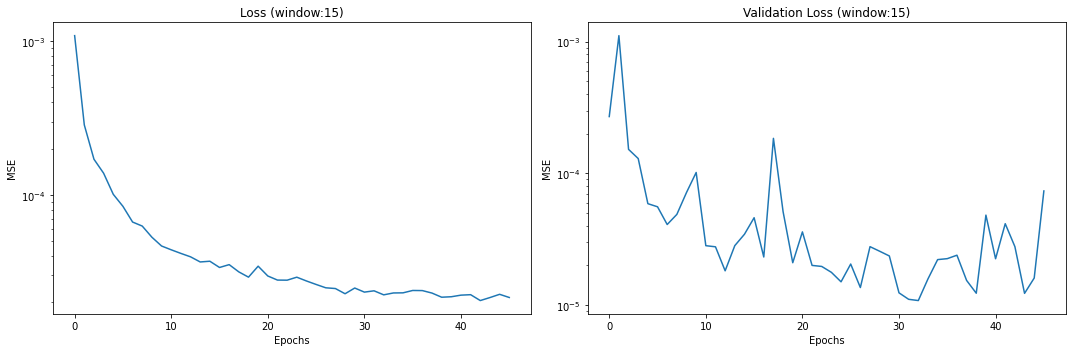

In [30]:
history_plot(history,window_size)

Save history data

In [31]:
hist_df = pd.DataFrame(history) 
# save to json:  
hist_json_file = f'history_tdnn_{window_size}.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

To load history data use:

In [32]:
#history = pd.read_json('history_tdnn_15.json')

Save the model

In [33]:
hypermodel.save(f'keras_model_tdnn_{window_size}')

2023-05-12 09:14:44.277176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_6_input' with dtype float and shape [?,1,15]
	 [[{{node dense_6_input}}]]
2023-05-12 09:14:44.308268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_6_input' with dtype float and shape [?,1,15]
	 [[{{node dense_6_input}}]]
2023-05-12 09:14:44.321182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,15]
	 [[{{n

INFO:tensorflow:Assets written to: keras_model_tdnn_15/assets


INFO:tensorflow:Assets written to: keras_model_tdnn_15/assets


Command to (eventually) load the saved model:

In [34]:
#hypermodel = keras.models.load_model('keras_model_tdnn_15')

calculate mse on validation data

In [35]:
mse15 = hypermodel.evaluate(validX, validY, batch_size=bs)[0]

985/985 [==============================] - 1s 1ms/step - loss: 7.3586e-05 - mean_squared_error: 7.3586e-05


# Compare the results with the two window sizes

In [36]:
print(f'mse with window 10 = {mse10}')
print(f'mse with window 15 = {mse15}')

mse with window 10 = 0.0004784019838552922
mse with window 15 = 7.358624134212732e-05


In [37]:
if mse10 < mse15:
    print('window 10 is better')
    w = 10
    hypermodel = keras.models.load_model('keras_model_tdnn_10')
else:
    print('window 15 is better')
    w = 15
    hypermodel = keras.models.load_model('keras_model_tdnn_15')

window 15 is better


# Plots of target and output signals over time (of the best model)

In [38]:
#prepare the data
trainX, trainY = get_XY(x_train, y_train, w)
validX, validY = get_XY(x_valid, y_valid, w)
testX, testY = get_XY(x_test, y_test, w)

#check shape
print(trainX.shape,trainY.shape)

(3985, 1, 15) (3985,)


4985/4985 [==============================] - 5s 1ms/step - loss: 7.4171e-05 - mean_squared_error: 7.4171e-05


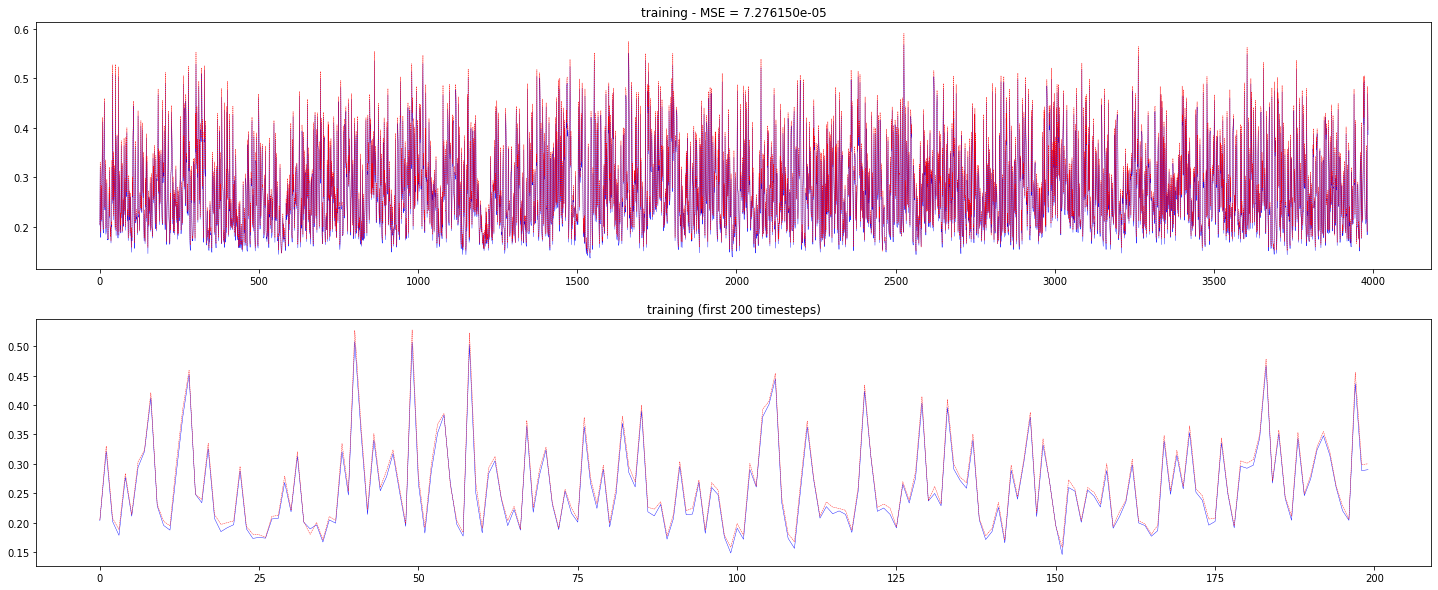

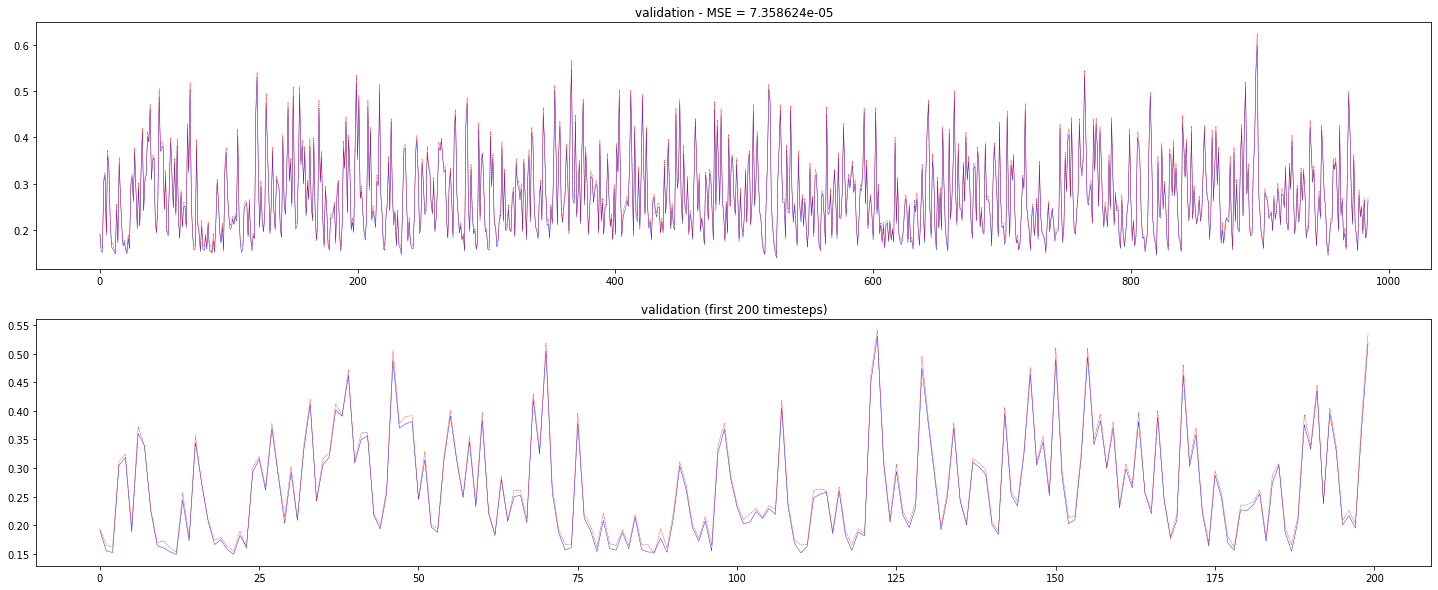

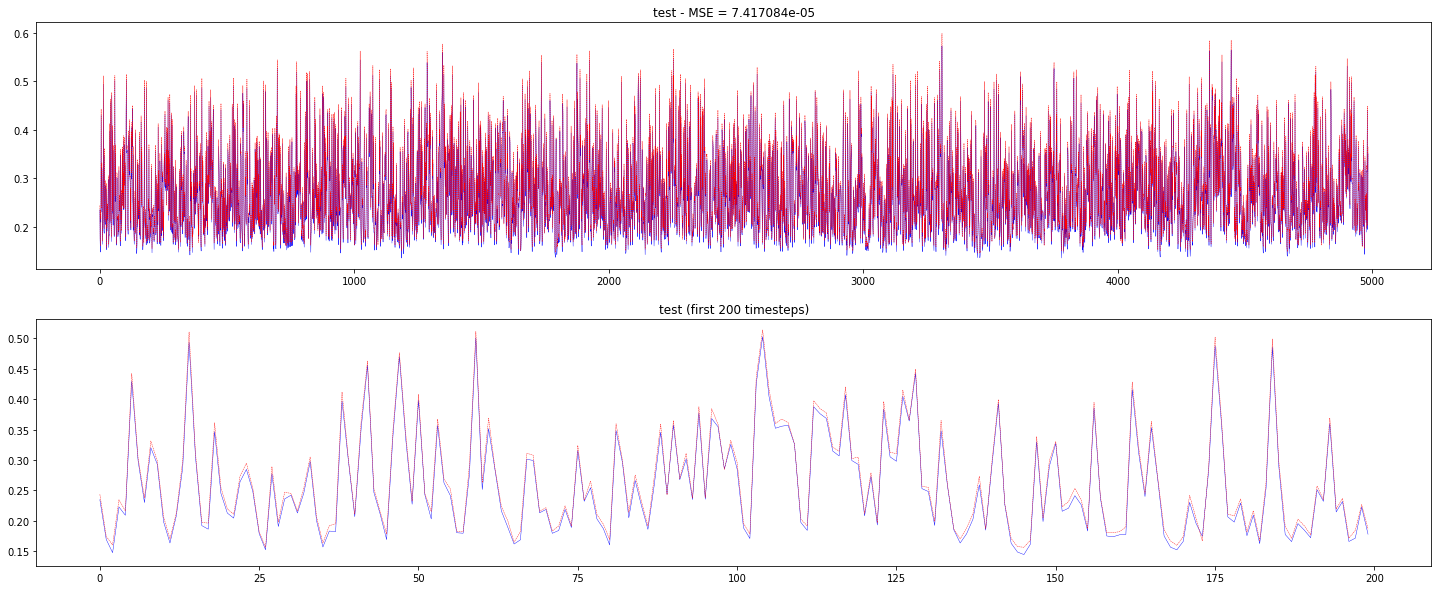

In [39]:
#training
y = hypermodel.predict(trainX)
mse = hypermodel.evaluate(trainX, trainY, batch_size=bs)[0]
t=np.arange(start=0,stop=len(y), step=1)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'training - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t,trainY.ravel(), color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')

plt.subplot(212)
plt.title('training (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t[:200],trainY.ravel()[:200], color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.savefig(f"plots/tdnn_training_{w}.pdf")

#validation
y = hypermodel.predict(validX)
mse = hypermodel.evaluate(validX, validY, batch_size=bs)[0]
t=np.arange(start=0,stop=len(y), step=1)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'validation - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t,validY.ravel(), color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')

plt.subplot(212)
plt.title('validation (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t[:200],validY.ravel()[:200], color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.savefig(f"plots/tdnn_validation_{w}.pdf")

#test
y = hypermodel.predict(testX)
mse = hypermodel.evaluate(testX, testY, batch_size=bs)[0]
t=np.arange(start=0,stop=len(y), step=1)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'test - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t,testY.ravel(), color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')

plt.subplot(212)
plt.title('test (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t[:200],testY.ravel()[:200], color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.savefig(f"plots/tdnn_test_{w}.pdf")
